# Bayesian sampling of the posterior distribution

The posterior distribution is defined over the set of structural ensembles with the same functional form as the optimal solution of Ensemble Refinement, parametrized by $\vec\lambda$. Alternatively, you could also have a set of structural ensembles given by some free/flexible coefficients of a force-field correction, or the most general variational freedom of ensembles defined over an arbitrary n. of frames.

The posterior distribution is given by the exponential of minus the loss function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from basic_functions_bayesian import local_density, compute_single, compute
from basic_functions_bayesian import run_Metropolis, block_analysis

In [3]:
alpha = 1  # the hyperparameter of Ensemble Refinement

## arbitrary form of probability distribution
to complete

In [4]:
import jax
import jax.numpy as jnp

In [5]:
def gaussian(x, pars):
    p = 1/jnp.sqrt(2*jnp.pi*pars[1])*jnp.exp(-((x - pars[0])**2)/2*pars[1])
    return p

In [6]:
def log_gaussian(x, pars):
    log_p = -1/2*jnp.log(2*jnp.pi*pars[1]) - (x - pars[0])**2/(2*pars[1])
    return log_p

In [55]:
def log_p(xs, pars, function):
    return jnp.log(function(xs, pars))

fun_forces = jax.jacfwd(log_p, argnums=1)

ders = np.array(fun_forces(xs, pars, gaussian))

p = gaussian(xs, pars)
# p = np.exp(log_p(xs, pars, gaussian))

metric = np.einsum('i,ji,ki->jk', p, ders, ders)

triang = np.linalg.cholesky(metric)
measure = np.prod(np.diag(triang))

print(measure)

6.0624876


In [88]:
pars0 = np.array([0.0, 1.0])
xs = np.linspace(-10, 10, 100)
# lambdas0 = np.array([30.0])

def proposal(pars, dpars = 0.01):
    pars_new = pars + dpars*np.random.normal(size=len(pars))
    return pars_new

proposal_full = {'fun': proposal, 'args': ([0.01])}

def log_p(xs, pars, function):
    return jnp.log(function(xs, pars))

fun_derivatives = jax.jacfwd(log_p, argnums=1)

def energy_fun(pars, xs, function_p, function_ders):

    ders = np.array(function_ders(xs, pars, gaussian))

    p = function_p(xs, pars)
    # p = np.exp(log_p(xs, pars, gaussian))

    metric = np.einsum('i,ij,ik->jk', p, ders, ders)

    triang = np.linalg.cholesky(metric)
    
    # measure = np.prod(np.diag(triang))
    # energy = -np.log(measure)

    energy = -np.sum(np.diag(triang))
    
    return energy, None

In [89]:
energy_function = {'fun': energy_fun, 'args': ([xs, gaussian, fun_forces])}
out_J = run_Metropolis(pars0, proposal_full, energy_function, n_steps=1000)

0
100
200
300
400
500
600
700
800
900


0.993


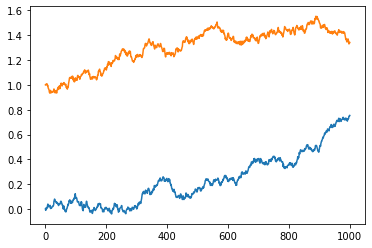

In [90]:
plt.plot(out_J[0])

print(out_J[2])

## 1st example: single experimental observable
i.e. 1-dimensional distribution

### define input values
probability distribution, observables...

- very small n. of frames and user-defined values of the observable

In [4]:
n = 2  # number of frames

# probability distribution:
p0 = [3/4, 1/4]
p0 = p0/np.sum(p0)

# value of the observable at these points:
g = np.array([0, 1])

# experimental value and error of the observable
gexp = 0.9
sigma = 0.2

- alternatively, significant n. of frames

In [5]:
n = 60  # n. frames

p0 = np.random.dirichlet(np.ones(n), size=n)[:, 0]
# p0 = np.ones(n)/n

#g=np.concatenate((np.random.normal(0,size=np.int(N/2)),np.random.normal(1,size=np.int(N/2))))
x = np.random.normal(1, 0.2, size=n)

# g = x
g = x**2
# g = 1/x**2

gexp = 1.5
sigma = 0.3

In [212]:
var = 0.1
n = 25

if not np.mod(n, 2) == 0: n += 1

g = np.concatenate([np.random.normal(0, np.sqrt(var), size=n//2), np.random.normal(1, np.sqrt(var), size=n//2)])

p0 = np.ones(n)
p0 /= p0

gexp = 0.8
sigma = 0.1

- some illustrative cases:

In [5]:
n = 6000  # n. frames

p0 = np.random.dirichlet(np.ones(n), size=None)
# p0 = np.ones(n)/n

#g=np.concatenate((np.random.normal(0,size=np.int(N/2)),np.random.normal(1,size=np.int(N/2))))
x = np.random.normal(1, 0.2, size=n)

# g = x
g = x**2
# g = 1/x**2

gexp = 3.2
sigma = 0.3

In [6]:
dlambda = 1e-1
lambdamax = 20
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)

ns = [10, 20, 50, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5]

how_many = []
vals = []

for n in ns:

    n = np.int(n)

    p0 = np.random.dirichlet(np.ones(n), size=None)

    x = np.random.normal(1, 0.2, size=n)
    g = x**2

    gexp = 3.2
    sigma = 0.3

    wh = np.where(g > gexp)[0]
    how_many.append(len(wh))

    g = np.delete(g, wh)
    p0 = np.delete(p0, wh)

    print(how_many[-1])

    results = compute(lambdas, p0, g, gexp, sigma, alpha)

    x_min = np.argwhere(g == np.min(g))[0]
    x_max = np.argwhere(g == np.max(g))[0]

    lim_values = [-alpha*np.log(p0[x_max]) + 1/2*((np.max(g) - gexp)/sigma)**2,
        -alpha*np.log(p0[x_min]) + 1/2*((np.min(g) - gexp)/sigma)**2]

    print('exact values: ', lim_values)
    print(results['lossf'][0], results['lossf'][-1])

    print('min. value of the loss: ', np.min(results['lossf']))

    diff = np.min(lim_values - np.min(results['lossf']))
    print('diff: ', diff)

    vals.append(lim_values + [results['lossf'][0], results['lossf'][-1], np.min(results['lossf']), diff])


0
exact values:  [array([3.63497325]), array([40.01569978])]
3.6347565201291534 38.97053465879426
min. value of the loss:  3.626929698769083
diff:  0.008043551510265257
0
exact values:  [array([15.76876934]), array([48.15521894])]
15.663897806633061 47.20234303473821
min. value of the loss:  15.582605650037294
diff:  0.18616368950604212
0
exact values:  [array([10.91248077]), array([51.43055185])]
10.872244387569596 48.75127383837569
min. value of the loss:  10.864257182375955
diff:  0.04822358470054233
0
exact values:  [array([7.29229081]), array([51.85914422])]
7.222493541096546 49.1752347581965
min. value of the loss:  6.8930868645107815
diff:  0.39920394501745626
0
exact values:  [array([8.97198979]), array([51.35303535])]
8.863872611537712 48.96773961765528
min. value of the loss:  8.77190872916765
diff:  0.2000810573081786
0
exact values:  [array([13.38697299]), array([59.01509263])]
10.771843151338707 55.47838400122599
min. value of the loss:  10.28313784803186
diff:  3.10383514

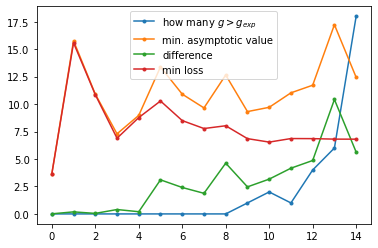

In [7]:
diff = [vals[i][-1] for i in range(len(vals))]

min_asymp = np.array([vals[i][0] for i in range(len(vals))])
max_asymp = np.array([vals[i][1] for i in range(len(vals))])

min_val = np.array([vals[i][4] for i in range(len(vals))])

plt.plot(how_many, '.-', label=r'how many $g > g_{exp}$')
plt.plot(min_asymp, '.-', label='min. asymptotic value')
plt.plot(diff, '.-', label='difference')
plt.plot(min_val, '.-', label='min loss')

# print(min_asymp, max_asymp)
plt.legend()

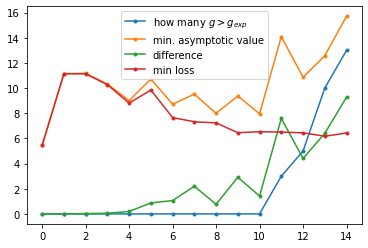

In [6]:
diff = [vals[i][-1] for i in range(len(vals))]

min_asymp = np.array([vals[i][0] for i in range(len(vals))])
max_asymp = np.array([vals[i][1] for i in range(len(vals))])

min_val = np.array([vals[i][4] for i in range(len(vals))])

plt.plot(how_many, '.-', label=r'how many $g > g_{exp}$')
plt.plot(min_asymp, '.-', label='min. asymptotic value')
plt.plot(diff, '.-', label='difference')
plt.plot(min_val, '.-', label='min loss')

# print(min_asymp, max_asymp)
plt.legend()

Text(0.5, 0, 'n frames')

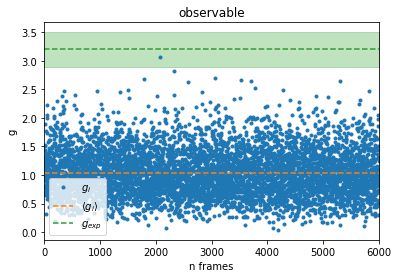

In [7]:
plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma, gexp - sigma], [gexp + sigma, gexp + sigma], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

In [8]:
dlambda = 1e-1
lambdamax = 20
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)

# lambdas = np.linspace(-lambdamax, lambdamax, n)

### compute and plot
as a function of lambda

In [9]:
out = compute_single(0.3, p0, g, gexp, sigma, alpha)

vars(out).keys()

dict_keys(['P', 'Z', 'av_g', 'av_g2', 'var_g', 'std_g', 'chi2', 'Srel', 'lossf', 'gamma', 'jeffreys', 'dirichlet', 'avg_density'])

In [10]:
results = compute(lambdas, p0, g, gexp, sigma, alpha)

results.keys()

dict_keys(['P', 'Z', 'av_g', 'av_g2', 'var_g', 'std_g', 'chi2', 'Srel', 'lossf', 'gamma', 'jeffreys', 'dirichlet', 'avg_density'])

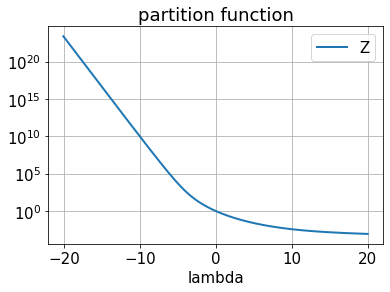

In [11]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2

plt.plot(lambdas, results['Z'], '-', label='Z')
plt.yscale('log')
plt.xlabel('lambda')
plt.title('partition function')
plt.legend()
plt.grid()

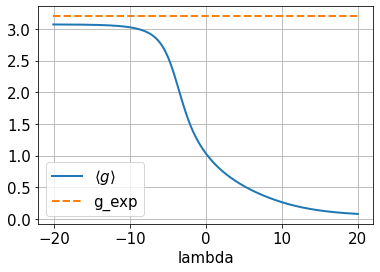

In [14]:
plt.plot(lambdas, results['av_g'], '-', label=r'$\langle g \rangle$')
plt.plot([lambdas[0], lambdas[-1]], [gexp, gexp], '--', label='g_exp')
#plt.yscale('log')
plt.xlabel('lambda')
plt.legend()
plt.grid()

- mantieni i dati incompatibili e aumenta il n. di frame: il valore asintotico della loss f. aumenta sempre, perciò non ho problemi di normalizzazione?

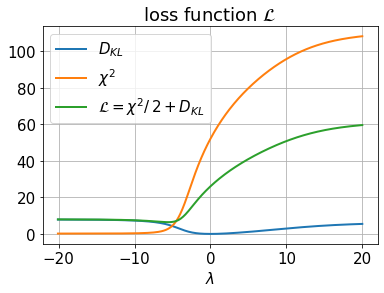

In [15]:
plt.plot(lambdas, -results['Srel'], '-', label=r'$D_{KL}$')
plt.plot(lambdas, results['chi2'], '-', label=r'$\chi^2$')
plt.plot(lambdas, -results['Srel'] + 1/2*results['chi2'][:, 0], '-', label=r'$\mathcal{L}=\chi^2/\,2+D_{KL}$')

plt.title(r'loss function $\mathcal{L}$')
#plt.yscale('log')
# plt.xlim([-50, 50])
plt.xlabel(r'$\lambda$')
plt.legend()
plt.grid()

in the limit of low/high $\lambda$, the limit value of $D_{KL}$ is $-\log P_0(\bar x)$ where $\bar x$ is the frame in which $g(x)$ takes its min/max value, respectively, and the limit value of $\chi^2$ is $\Bigl(\frac{g(\bar x) - g_{exp}}{\sigma_{exp}}\Bigr)^2$

notice you cannot expand perturbatively $e^{-\lambda (g-g_{min})}$ around $\lambda = -\infty$ (the same for $\lambda = +\infty$)

hence, if the n. of frames is high, the asymptotic value of the loss function is high, and in practice there is no critical issue about normalization of the hyper-ensemble

In [16]:
x_min = np.argwhere(g == np.min(g))[0]
x_max = np.argwhere(g == np.max(g))[0]

lim_values = [-alpha*np.log(p0[x_max]) + 1/2*((np.max(g) - gexp)/sigma)**2,
    -alpha*np.log(p0[x_min]) + 1/2*((np.min(g) - gexp)/sigma)**2]

print('exact values: ', lim_values)
print(results['lossf'][0], results['lossf'][-1])

print('min. value of the loss: ', np.min(results['lossf']))

exact values:  [array([7.98141993]), array([62.04137258])]
7.959465196945026 59.665237047389084
min. value of the loss:  6.435332583833343


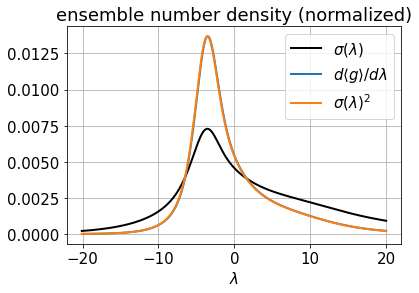

In [17]:
#plt.plot(lambdas,-np.log(std_gs),'-',label='- log std')

normalize = lambda x: x/np.sum(x)

plt.plot(lambdas, normalize(results['std_g']), '-', label=r'$\sigma(\lambda)$', c='k')
#plt.plot(lambdas,-2*np.log(std_gs),'-',label='- log variance')
#plt.plot(lambdas,-np.log(dirichlets),'-',label='equiv. for Dirichlet')

plt.plot(lambdas[1:], normalize(np.abs(np.ediff1d(results['av_g'])/np.ediff1d(lambdas))), '-', label=r'$d\langle g\rangle/d\lambda$')
plt.plot(lambdas, normalize(results['std_g']**2), '-', label=r'$\sigma(\lambda)^2$')

plt.xlabel(r'$\lambda$')
plt.grid()
plt.legend()
#plt.title('volume transformation')
# plt.xlim([-30, 30])
plt.title('ensemble number density (normalized)')
plt.show()

So we could say it is quite the same to use $\sigma d\lambda$ or $\sigma^2 d\lambda$, corresponding to measuring distances with Fisher metrics (namely, Jeffreys prior, KL divergence) or with $d\langle g \rangle$, respectively. However, there is the issue of dimensions: are there more ensembles in between 1 and 2 $\mu m$ or in between 1 and 2 $Hz$? It makes no sense, so let's use $\sigma d\lambda$ which is adimensional.

In [18]:
loss = results['lossf']
loss -= np.min(loss)

loss1 = loss - np.log(results['std_g'])
loss1 -= np.min(loss1)

loss2 = loss - 2*np.log(results['std_g'])
loss2 -= np.min(loss2)

gamma = results['gamma']

loss_dir = loss - np.log(results['dirichlet'])
loss_dir -= np.min(loss_dir)

delta = np.min(loss) - np.min(gamma)

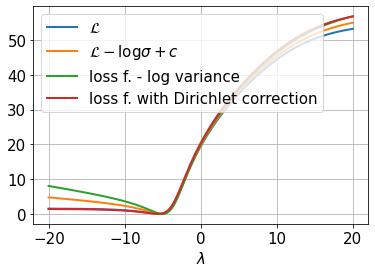

In [19]:
plt.plot(lambdas, loss, '-', label=r'$\mathcal{L}$')#loss f.')#,markersize=0.5)
plt.plot(lambdas, loss1, '-', label=r'$\mathcal{L}-\log\sigma+c$')
#plt.plot(lambdas,-loss+loss1,'-',label=r'$-\log\sigma$')

plt.plot(lambdas, loss2, '-', label='loss f. - log variance')
# plt.plot(lambdas, gamma, '-', label='gamma f.')
#plt.plot(lambdas,gamma+delta,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\lambda$')
# plt.yscale('symlog')

# plt.xlim([-30, 30])
# plt.ylim([-5,40])

plt.grid()

In [20]:
xmin_loss = lambdas[np.argwhere(loss == np.min(loss))[0][0]]
xmin_gamma = lambdas[np.argwhere(gamma == np.min(gamma))[0][0]]
xmin_1 = lambdas[np.argwhere(loss1 == np.min(loss1))[0][0]]
xmin_2 = lambdas[np.argwhere(loss2 == np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ', xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)


min. of the "original" loss function:  -5.599999999999795
min. of Gamma function:  -5.599999999999795
min. of the loss f. with std correction:  -5.299999999999791
min. of the loss f. with variance correction:  -5.099999999999788


so, the hyper probability distribution $P(\lambda)$ is:

In [21]:
hyper_P0 = np.exp(-loss)
hyper_P1 = np.exp(-loss1)
hyper_P2 = np.exp(-loss2)
hyper_P_gamma = np.exp(-gamma)
hyper_P_dir = np.exp(-loss_dir)

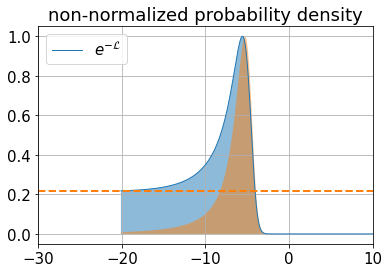

In [22]:
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 15

plt.plot(lambdas, hyper_P0, label=r'$e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)
#plt.plot(lambdas,hyper_P_gamma,label='gamma')

#plt.plot(lambdas,hyper_P1,label=r'$\sigma \, e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P1, alpha=0.5)

#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
plt.xlim([-30, 10])
plt.plot([-30, 10], [hyper_P0[0], hyper_P0[0]], '--', linewidth=2)
#plt.yscale('log')
plt.grid()
plt.title('non-normalized probability density')
plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))

In [23]:
hyper_P0 = hyper_P0/np.sum(hyper_P0)
hyper_P1 = hyper_P1/np.sum(hyper_P1)
hyper_P2 = hyper_P2/np.sum(hyper_P2)
hyper_P_gamma = hyper_P_gamma/np.sum(hyper_P_gamma)
hyper_P_dir = hyper_P_dir/np.sum(hyper_P_dir)

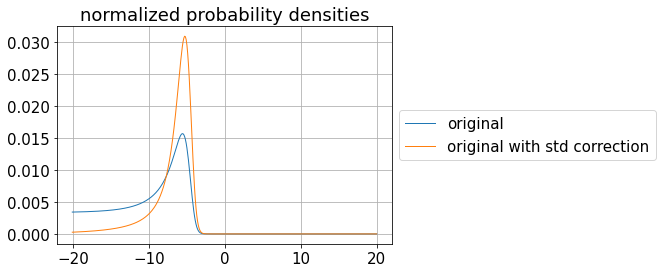

In [24]:
plt.plot(lambdas, hyper_P0, label='original')
#plt.plot(lambdas,hyper_P_gamma,label='gamma')
plt.plot(lambdas, hyper_P1, label='original with std correction')
#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
# plt.xlim([-30, 30])
#plt.yscale('log')
plt.grid()
plt.title('normalized probability densities')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Metropolis sampling

In [25]:
lambdas0 = np.zeros(1)
# lambdas0 = np.array([30.0])

def proposal(x0, dx = 0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.5])}

def energy_fun(lambdas, which_measure = None):
    """implicit input parameters: p0, g, gexp, sigma, alpha"""
    
    out = compute_single(lambdas, p0, g, gexp, sigma, alpha)
    
    energy = out.lossf
    av_g = out.av_g

    if which_measure is not None: energy -= np.log(vars(out)[which_measure])
    
    return energy, av_g

In [29]:
energy_function = {'fun': energy_fun, 'args': (['jeffreys'])}
out_J = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=100000)

energy_function = {'fun': energy_fun, 'args': ([None])}
out_noJ = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=100000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [30]:
print('acceptance: ', out_J[2], out_noJ[2])

acceptance:  0.8848 0.9616


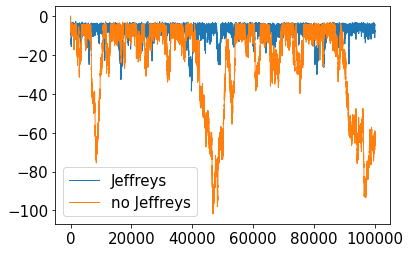

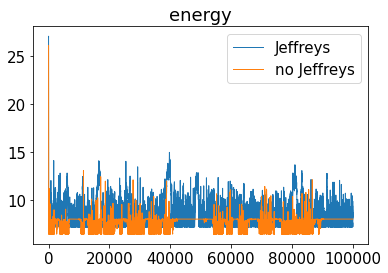

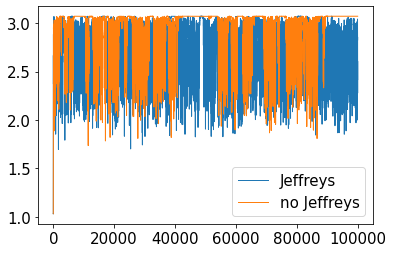

In [31]:
plt.plot(out_J[0], label='Jeffreys')
plt.plot(out_noJ[0], label='no Jeffreys')
plt.legend()

plt.figure()
plt.plot(out_J[1], label='Jeffreys')
plt.plot(out_noJ[1], label='no Jeffreys')
plt.title('energy')
plt.legend()

plt.figure()
plt.plot(out_J[3][:, 0], label='Jeffreys')
plt.plot(out_noJ[3][:, 0], label='no Jeffreys')
plt.legend()



In [52]:
av_J = np.mean(out_J[3], axis=0)
av_noJ = np.mean(out_noJ[3], axis=0)

print('averages: ', av_J, av_noJ)

# here you should use block analysis
std_J = np.std(out_J[3], axis=0)/np.sqrt(len(out_J[3]))
std_noJ = np.std(out_noJ[3], axis=0)/np.sqrt(len(out_noJ[3]))

print('std: ', std_J, std_noJ)

order_par = (np.sum((av_J - av_noJ)**2/(std_J**2 + std_noJ**2)))
print(order_par)

averages:  [1.34998782] [1.41890675]
std:  [0.00244284] [0.00324998]
287.3483591035645


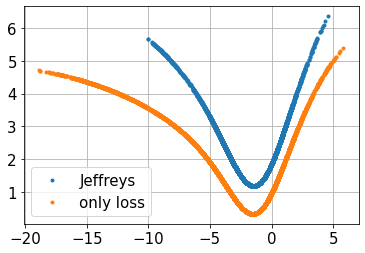

In [53]:
plt.plot(out_J[0], out_J[1], '.', label='Jeffreys')
plt.plot(out_noJ[0], out_noJ[1], '.', label='only loss')
plt.legend()
plt.grid()

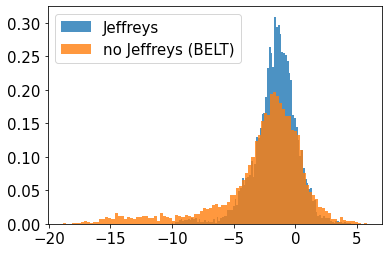

In [54]:
plt.hist(out_J[0], bins=100, alpha=0.8, density=True, label='Jeffreys')
plt.hist(out_noJ[0], bins=100, alpha=0.8, density=True, label='no Jeffreys (BELT)')
#plt.hist(traj3,bins=100)

plt.legend()

## 2nd example: some observables
4 peaks

In [8]:
# probability distribution:
p0 = [3, 4, 1, 1]

# normalize, if not normalized
p0 = p0/np.sum(p0)

# value of the observable at these points:
g = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T

# experimental value and error of the observable
gexp = [0.1, 0.8]
sigma = [0.2, 0.1]

print(p0.shape, g.shape)

(4,) (2, 4)


In [9]:
var = 0.1/30  # spread of the 4 peaks (assumption: the same for all)
how_many = 200  # times prop, it gives the population of the 4 peaks
prop = [1, 1, 1, 1]  # chosen proportion of the 4 peaks

g = np.concatenate((np.random.multivariate_normal(mean=(0, 0), cov=var*np.diag([1, 1]), size=prop[0]*how_many),
    np.random.multivariate_normal(mean=(0, 1), cov=var*np.diag([1, 1]), size=prop[1]*how_many),
    np.random.multivariate_normal(mean=(1, 0), cov=var*np.diag([1, 1]), size=prop[2]*how_many),
    np.random.multivariate_normal(mean=(1, 1), cov=var*np.diag([1, 1]), size=prop[3]*how_many))).T

p0 = np.ones(len(g.T))  # different n. of points in each Gaussian
p0 = p0/np.sum(p0)

gexp = [0.1, 0.8]
sigma = [0.2, 0.1]

[0.1, 0.8] [0.2, 0.1]


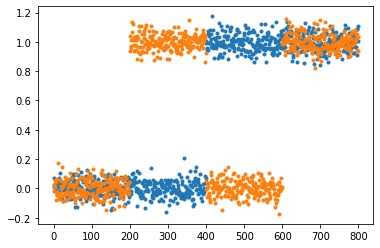

In [10]:
plt.plot(g.T, '.')

print(gexp, sigma)

# plt.plot([-5, len(g.T) + 5], [np.mean(g.T), np.mean(g.T)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

# plt.plot([-5, len(g.T) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
# plt.fill_between([-5, len(g) + 5], [gexp - sigma, gexp - sigma], [gexp + sigma, gexp + sigma], alpha=0.3, color='tab:green')


In [11]:
lambda_i = [1, 1]

out = compute_single(lambda_i, p0, g, gexp, sigma, alpha)

vars(out)

{'P': array([0.00242333, 0.00257957, 0.00265692, 0.00257534, 0.00257476,
        0.00284987, 0.00254968, 0.00269108, 0.00262777, 0.00262521,
        0.00268285, 0.00216396, 0.0027666 , 0.00275484, 0.0026469 ,
        0.00279848, 0.00240944, 0.0025744 , 0.00260644, 0.00267086,
        0.00249711, 0.00262723, 0.00296029, 0.0024521 , 0.00294643,
        0.00284873, 0.00271129, 0.00255021, 0.00243765, 0.00271681,
        0.00256746, 0.00244457, 0.002914  , 0.00273412, 0.0026028 ,
        0.00276084, 0.00293523, 0.00239833, 0.00258755, 0.00270391,
        0.00304439, 0.00291741, 0.00239211, 0.00280405, 0.00261324,
        0.00256644, 0.00294621, 0.00230811, 0.00284376, 0.00262399,
        0.00249642, 0.00253104, 0.00251654, 0.00305211, 0.00250777,
        0.00326233, 0.00262195, 0.00291866, 0.00244399, 0.00234691,
        0.002889  , 0.00263204, 0.00260562, 0.00276349, 0.00256782,
        0.00214298, 0.00265698, 0.00255741, 0.00275087, 0.00267377,
        0.00289622, 0.00279671, 0.00278999,

In [22]:
lambdas = np.linspace(-30, 30, 100)

my_grid = np.meshgrid(lambdas, lambdas)

out = {}

for l1 in lambdas:
    out[l1] = {}
    for l2 in lambdas:
        out[l1][l2] = vars(compute_single(np.array([l1, l2]), p0, g, gexp, sigma, alpha))

In [29]:
lambdas_long = np.linspace(-200, 200, 400)

for l1 in lambdas_long:
    out[l1] = vars(compute_single(np.array([l1, lambdas[len(lambdas)//2]]), p0, g, gexp, sigma, alpha))


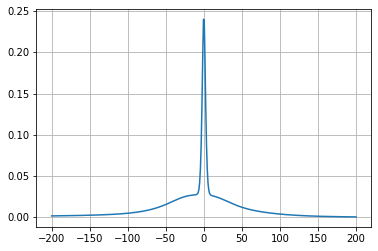

In [30]:
vec = [out[l2]['jeffreys'] for l2 in lambdas_long]

plt.plot(lambdas_long, vec)
plt.grid()

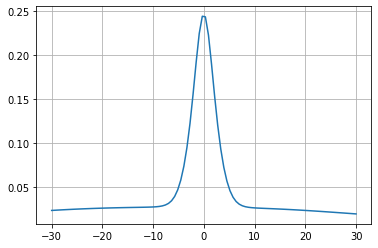

In [33]:
vec = np.array([out[l1][lambdas[len(lambdas)//2]]['jeffreys'] for l1 in lambdas])

plt.plot(lambdas, vec)
# plt.yscale('log')
plt.grid()



/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify th

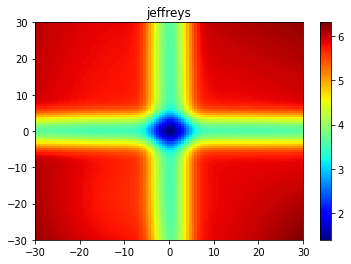

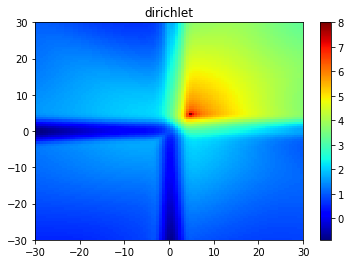

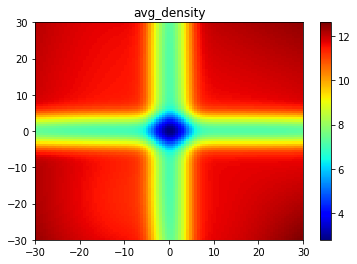

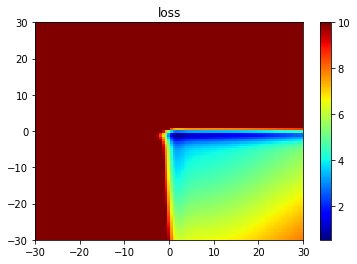

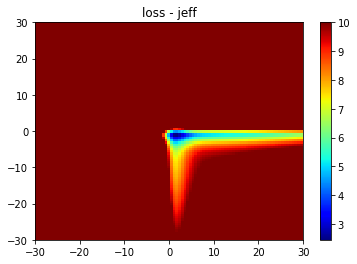

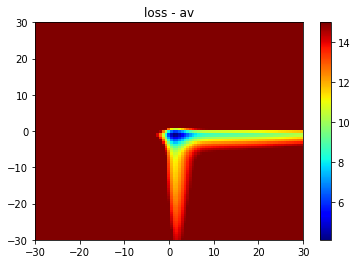

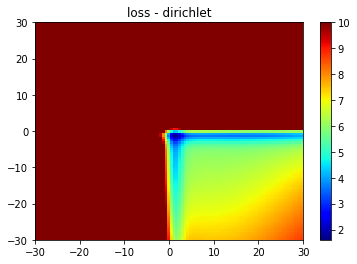

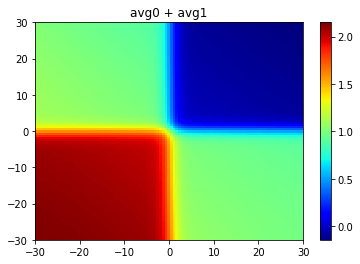

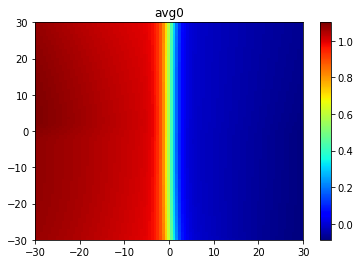

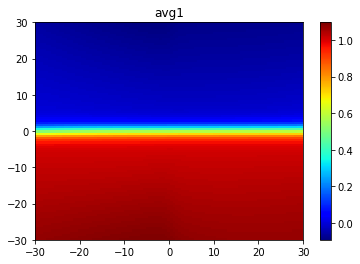

In [24]:
flatten = lambda out, s: np.array([[out[l1][l2][s] for l1 in lambdas] for l2 in lambdas])

loss = flatten(out, 'lossf')

avgs = flatten(out, 'av_g')
avg0 = avgs[:, :, 0]
avg1 = avgs[:, :, 1]

# plt.imshow(lambdas, lambdas, loss, 'jet')
# plt.pcolormesh(lambdas, lambdas, loss, cmap='jet')
for s in ['jeffreys', 'dirichlet', 'avg_density']:
    plt.figure()
    plt.pcolormesh(lambdas, lambdas, -np.log(flatten(out, s)), cmap='jet')
    plt.title(s)
    plt.colorbar()

plt.figure()
plt.title('loss')
plt.pcolormesh(lambdas, lambdas, loss, cmap='jet', vmax=10)
plt.colorbar()

plt.figure()
plt.title('loss - jeff')
plt.pcolormesh(lambdas, lambdas, loss - np.log(flatten(out, 'jeffreys')), cmap='jet', vmax=10)
plt.colorbar()

plt.figure()
plt.title('loss - av')
plt.pcolormesh(lambdas, lambdas, loss - np.log(flatten(out, 'avg_density')), cmap='jet', vmax=15)
plt.colorbar()

plt.figure()
plt.title('loss - dirichlet')
plt.pcolormesh(lambdas, lambdas, loss - np.log(flatten(out, 'dirichlet')), cmap='jet', vmax=10)
plt.colorbar()



plt.figure()
plt.title('avg0 + avg1')
plt.pcolormesh(lambdas, lambdas, avg0 + avg1, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg0')
plt.pcolormesh(lambdas, lambdas, avg0, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg1')
plt.pcolormesh(lambdas, lambdas, avg1, cmap='jet')
plt.colorbar()
plt.show()

In [25]:
lambdas0 = np.zeros(2)

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.5])}

def energy_fun(lambdas, which_measure = None):
    
    out = compute_single(lambdas, p0, g, gexp, sigma, alpha)
    
    energy = out.lossf

    av_g = out.av_g

    if which_measure is not None:
        measure = local_density(g.T, out.P, which_measure=which_measure)[0]
        energy -= np.log(measure)
    
    return energy, av_g

In [26]:
which_measures = [None, 'jeffreys', 'average', 'dirichlet']

out = {}

for which_measure in which_measures:
    energy_function = {'fun': energy_fun, 'args': ([which_measure])}
    out[which_measure] = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=10000)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
60

In [27]:
print('acceptance: ', [(wm, out[wm][2]) for wm in out.keys()])

acceptance:  [(None, 0.8083), ('jeffreys', 0.7168), ('average', 0.6571), ('dirichlet', 0.8236)]


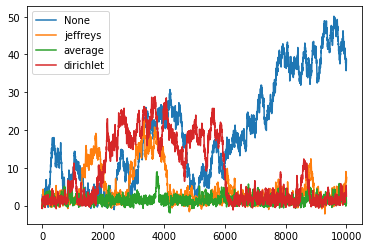

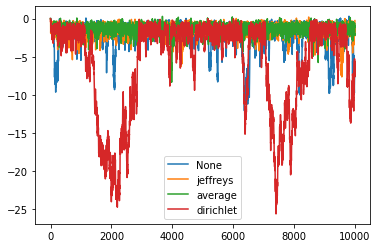

In [28]:
plt.figure()

for wm in out.keys():
    plt.plot(out[wm][0][:, 0], label=str(wm))
plt.legend()

plt.figure()

for wm in out.keys():
    plt.plot(out[wm][0][:, 1], label=str(wm))
plt.legend()

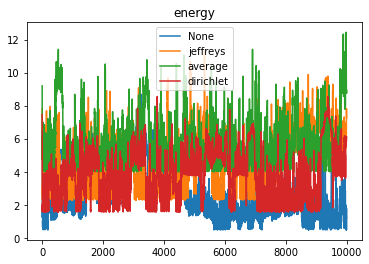

In [39]:
plt.figure()

for wm in out.keys():
    plt.plot(out[wm][1], label=str(wm))

plt.title('energy')
plt.legend()

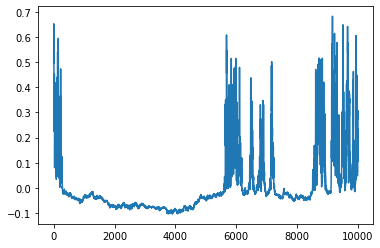

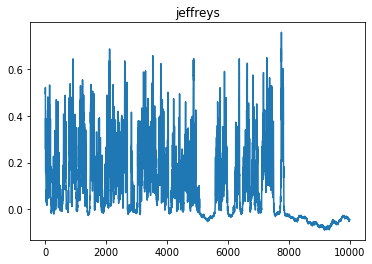

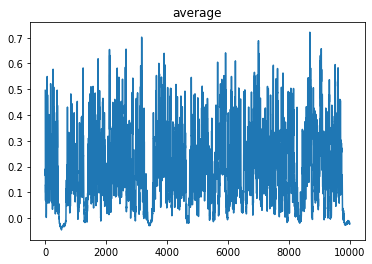

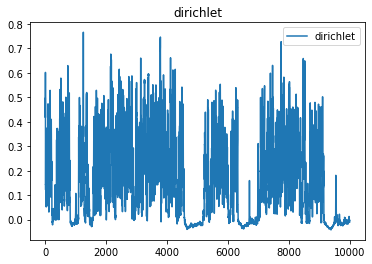

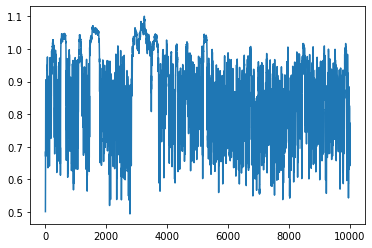

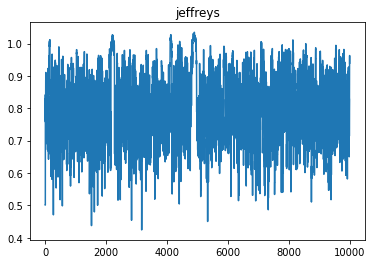

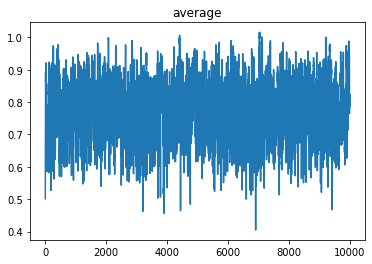

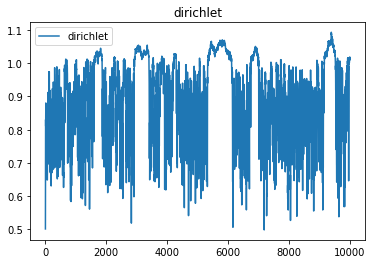

In [40]:
for wm in out.keys():
    plt.figure()
    plt.plot(out[wm][3][:, 0], label=str(wm))
    plt.title(wm)
plt.legend()

for wm in out.keys():
    plt.figure()
    plt.plot(out[wm][3][:, 1], label=str(wm))
    plt.title(wm)
plt.legend()

In [35]:
out.keys()

dict_keys([None, 'jeffreys', 'average', 'dirichlet'])

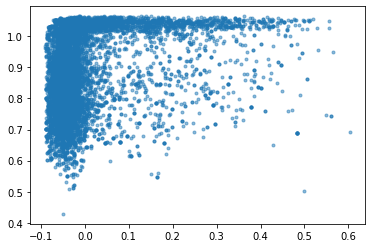

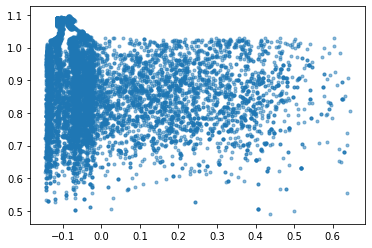

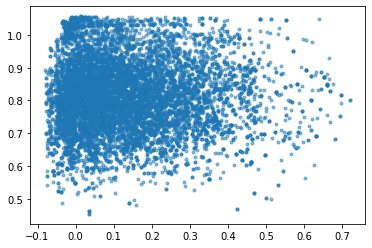

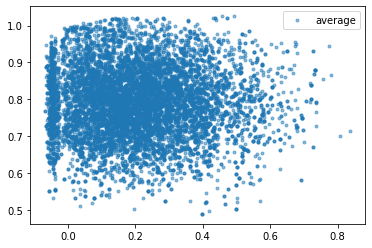

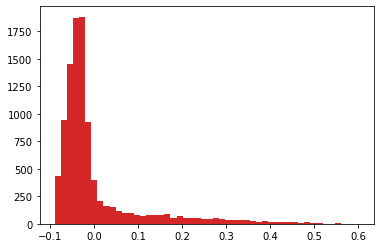

In [45]:
wm = 'jeffreys'

for wm in [None, 'dirichlet', 'jeffreys', 'average']:
    plt.figure()
    plt.plot(out[wm][3][:, 0], out[wm][3][:, 1], '.', label=str(wm), alpha=0.5)

plt.legend()


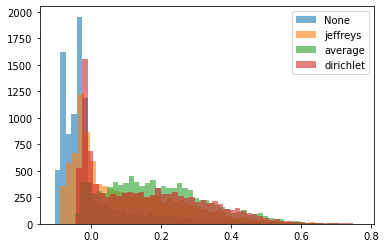

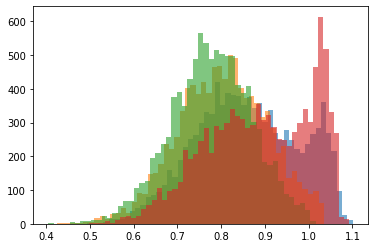

In [41]:
plt.figure()
for wm in out.keys():
    plt.hist(out[wm][3][:, 0], bins=50, label=str(wm), alpha=0.6)

plt.legend()

plt.figure()
for wm in out.keys():
    plt.hist(out[wm][3][:, 1], bins=50, label=str(wm), alpha=0.6)

In [88]:
av = {}
std = {}

for wm in out.keys():
    av[str(wm)] = np.mean(out[wm][3], axis=0)
    std[str(wm)] = np.std(out[wm][3], axis=0)/np.sqrt(len(out[wm][3]))

print('averages: ', av)
print('std: ', std)

order_par = (np.sum((av['jeffreys'] - av['None'])**2/(std['jeffreys']**2 + std['None']**2)))
print(order_par)

averages:  {'None': array([0.04530515, 0.90770403]), 'jeffreys': array([0.0204488 , 0.80258964]), 'average': array([0.21759733, 0.77919976]), 'dirichlet': array([0.12001313, 0.91848218])}
std:  {'None': array([0.00116885, 0.00126145]), 'jeffreys': array([0.00131763, 0.00097832]), 'average': array([0.00146403, 0.00093087]), 'dirichlet': array([0.00159942, 0.00110426])}
4534.87038268269


## Giovanni's trials:
- invariance w.r.t. number of frames
- data incompatible with trajectory

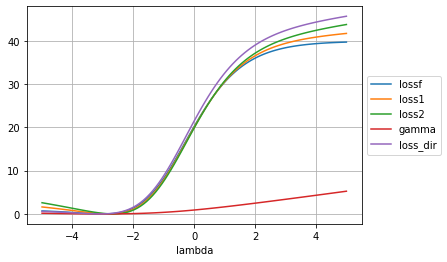

In [8]:
N = 1
P0 = np.array([3.]*N + [1.]*N)
P0 /= np.sum(P0)
g = np.array([0]*N + [1]*N)

gexp = 0.9
sigma = 0.1

lambdas = np.linspace(-5, 5, 100)

out = compute(lambdas, P0, g, gexp, sigma, alpha)

out['loss1'] = out['lossf'] - np.log(out['std_g'])
out['loss2'] = out['lossf'] - 2*np.log(out['std_g'])
out['loss_dir'] = out['lossf'] - np.log(out['dirichlet'])

for s in ['lossf', 'loss1', 'loss2', 'gamma', 'loss_dir']:
    
    out[s] -= np.min(out[s])
    plt.plot(lambdas, out[s], '-', label=s)  # ,markersize=0.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
# plt.ylim([-5, 20])
plt.grid()

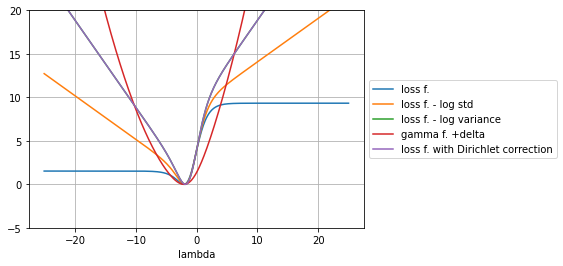

In [11]:
# invariance wrt number of frames:
N=1000
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

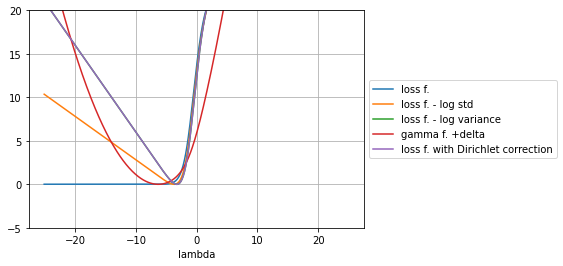

In [20]:
# data incompatible with trajectory
N=1
P0=np.array([3.]*N + [1.]*N)
P0/=np.sum(P0)
g=np.array([0]*N + [1]*N)

gexp=1.5



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)



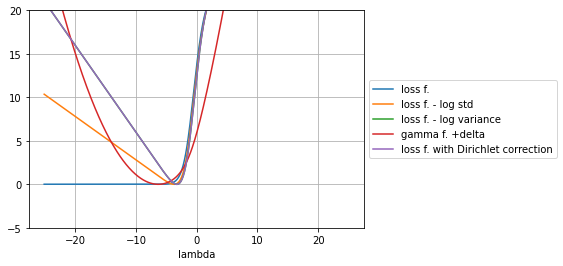

In [23]:
plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

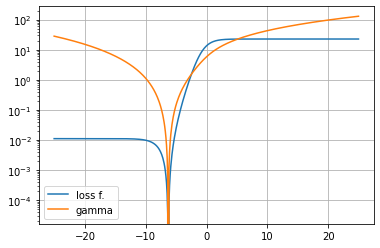

In [29]:
plt.plot(lambdas,loss,label='loss f.')
plt.plot(lambdas,gamma,label='gamma')
plt.yscale('log')
plt.legend()
plt.grid()


In [21]:
xmin_loss=lambdas[np.argwhere(loss==np.min(loss))[0][0]]
xmin_gamma=lambdas[np.argwhere(gamma==np.min(gamma))[0][0]]
xmin_1=lambdas[np.argwhere(loss1==np.min(loss1))[0][0]]
xmin_2=lambdas[np.argwhere(loss2==np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ',xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)

min. of the "original" loss function:  -6.299999999999734
min. of Gamma function:  -6.299999999999734
min. of the loss f. with std correction:  -3.6999999999996973
min. of the loss f. with variance correction:  -3.2999999999996916


### coarse graining

In [50]:

P0s=[np.array([1/3, 2/3]),np.array([1/3, 1/3, 1/3]),np.array([1/3, 0, 2/3])] # normalized
g2p=np.array([1,2])
g3p=np.array([1,2,2])
gs=[g2p,g3p,g3p]

gexp=0.9

In [51]:
Srels=[]
for i in range(len(P0s)):
    Srels.append(compute(lambdas,P0s[i],gs[i],gexp,sigma,alpha)[6])

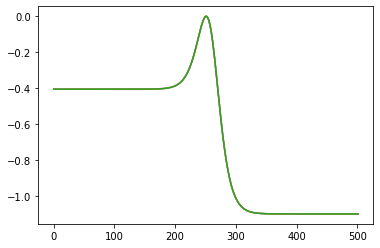

In [52]:
for Srel in Srels:
    plt.plot(Srel,'-')